<a href="https://colab.research.google.com/github/joydeep03564/Machine_Learning-/blob/master/Semantic%20Segmentation%20using%20Cityscape_dataset%20in%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mounting the drive :
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Unzipping the folders 
# Unzipping the left image folder 

import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/leftImg8bit_trainvaltest.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final")

In [2]:
#unziping the ground truth
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/gtFine_trainvaltest.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final")

In [4]:
!ls /content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final


gtFine	leftImg8bit  license.txt  README


In [5]:
!ls /content/drive/MyDrive/Dissertation_project/CityScape_Dataset/data/gtFine

test  train  val


In [6]:
!ls /content/drive/MyDrive/Dissertation_project/CityScape_Dataset/data/leftImg8bit

test  train  val


In [7]:
!nvidia-smi

Fri Mar 11 10:42:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot  as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn




In [9]:
dataset = Cityscapes('/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final',split='train',mode='fine',target_type='semantic')

In [10]:
dataset[0][0].size

(2048, 1024)

In [11]:
dataset[0][1].size

(2048, 1024)

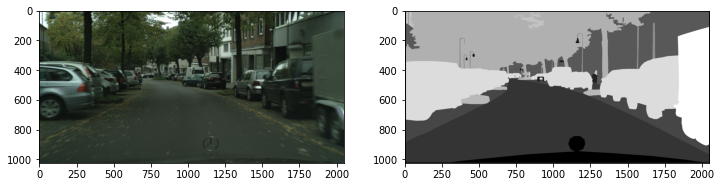

In [12]:
fig,ax = plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

### Some helper functions :
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

From this script, we can understand that there are labels "ego vehicle","unlabeled","static" etc 
and the categories are void. We are going to create a single categories out of all the classes. We are going to ignore all the trainID 255.


In [13]:
ignore_index =255

void_classes = [0,1,2,3,4,5,6,9,10,14,15,16,18,29,30,-1]
valid_classes = [ignore_index,7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33]
class_names =['unlabelled','road','sidewalk','building','wall','fence','pole','traffic_light',\
              'traffic_sign','vegitation','terrain','sky','person','rider','car','truck','bus',\
              'train','motorcycle','bicycle']

class_map = dict(zip(valid_classes,range(len(valid_classes))))
n_classes  = len(valid_classes)
class_map

{7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19,
 255: 0}

In [27]:
colors = [[0,0,0],
          [128, 64,128],
          [244,35,232],
          [70,70,70],
          [102,102,156],
          [190,153,153],
          [153,153,153],
          [250,170,30],
          [220,220,0],
          [107,142,35],
          [152,251,152],
          [0,130,180],
          [220,20,60],
          [255,0,0],
          [0,0,142],
          [0,0,70],
          [0,60,100],
          [0,80,100],
          [0,0,230],
          [119,11,32],
          ]

label_colors = dict(zip(range(n_classes),colors))

In [14]:
def encode_segmap(mask):

  for _voidc in void_classes:
    mask[mask==_voidc] = ignore_index
  for _voidc in valid_classes:
    mask[mask==_voidc]=class_map[_voidc]

  return mask

In [15]:
def decode_segmap(temp):
  # Convert gray scale image to color
  temp = temp.numpy()
  r = temp.copy()
  g = temp.copy()
  b = temp.copy()

  for l in range(0,n_classes):
    r[temp==l]= label_colors[l][0]
    g[temp==l]=label_colors[l][1]
    b[temp==l]= label_colors[l][2]

  rgb = np.zeros((temp.shape[0],temp.shape[1],3))
  rgb[:,:,0]= r/255.0
  rgb[:,:,1]= g/255.0
  rgb[:,:,2]= b/255.0

  return rgb

In [16]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 9.9 MB/s 
     |████████████████████████████████| 948 kB 53.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ae58589fb7840f643c2474e5ef1e67f143f26f6a09ba5c94c7d07b060e94c161
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [17]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose(
    [
     A.Resize(256,512),
     A.HorizontalFlip(),
     A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
     ToTensorV2(),
    ]
)

In [18]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class Myclass(Cityscapes):

  def __getitem__(self, index: int) -> Tuple[Any, Any]:
     image = Image.open(self.images[index]).convert('RGB')

     targets: Any = []
     for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

     target = tuple(targets) if len(targets) > 1 else targets[0]

     if self.transforms is not None:
            transformed = transform(image=np.array(image), mask=np.array(target))



     return transformed['image'],transformed['mask']
      




    

  

In [19]:
dataset= Myclass("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final/",split='train',mode='fine',target_type='semantic',transform=transform)

In [22]:
img,seg = dataset[200]

print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


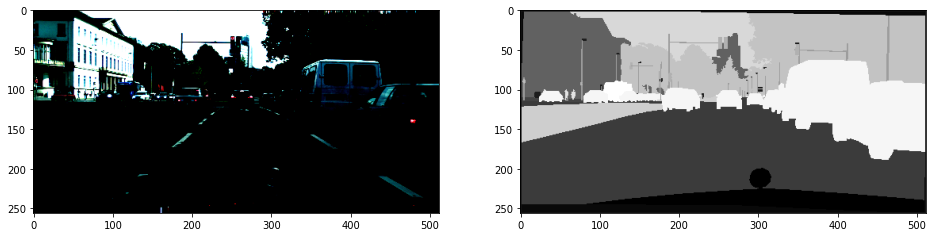

In [23]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(seg,cmap='gray')

In [24]:
# Class labels before label correction 
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  2,  3,  4,  7,  8, 11, 17, 19, 20, 21, 22, 23, 24, 26, 27],
       dtype=torch.uint8)
16


In [25]:
#class labels after label correction 

res = encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 14, 15], dtype=torch.uint8)
13


In [28]:
res1 = decode_segmap(res.clone())

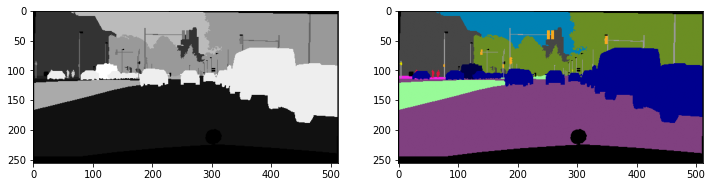

In [29]:

fig,ax = plt.subplots(ncols=2,figsize=(12,10))
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

# Training 

In [30]:

!pip install pytorch-lightning
  

     |████████████████████████████████| 527 kB 8.6 MB/s 
     |████████████████████████████████| 397 kB 49.5 MB/s 
     |████████████████████████████████| 952 kB 45.3 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 829 kB 53.7 MB/s 
     |████████████████████████████████| 134 kB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 63.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=440226b2d201f96965b9be4d8cc74b555c94ab0f81e353c8a6029466216f0169
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [31]:
!pip install segmentation-models-pytorch


     |████████████████████████████████| 88 kB 4.7 MB/s 
     |████████████████████████████████| 376 kB 35.1 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=73b57e3deef47ff35ed4e9a78c4c5d38f4d10fa9005c53fb6a0d0235e1cc167b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=70d079fd91c552c565b5e3c1878bd63dea75042108a34f52b9e005f78a3a1c3d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [32]:
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp


In [35]:
from random import shuffle
from pytorch_lightning import seed_everything,LightningModule,Trainer
import multiprocessing
import torchmetrics
import torch

class OurModel(LightningModule):

 def __init__(self):

    super(OurModel,self).__init__()


    self.layer = smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",in_channels=3,classes=n_classes)
    # Parameters 

    self.lr = 1e-3
    self.batch_size =32
    self.numworker = multiprocessing.cpu_count()//4

    self.criterion = smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.IoU(num_classes=n_classes)

    self.train_class = Myclass("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final/",split='train',mode='fine',
                               target_type='semantic',transforms=transform)
    self.val_class = Myclass("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/dataset_final/",split='val',mode='fine',
                             target_type='semantic',transform=transform)
    
 def process(self,image,segment):
      out = self(image)
      segment=encode_segmap(segment)
      loss = self.criterion(out,segment.long())
      iou = self.metrics(out,segment)
      return loss,iou

 def forward(self,x):
      return self.layer(x)

 
 def configure_optimizers(self):
   opt = torch.optim.AdamW(self.parameters(),lr=self.lr)
   return opt
 def train_dataloader(self):
    return DataLoader(self.train_class,batch_size=self.batch_size,shuffle=False,
                        pin_memory=True)   

 def training_step(self,batch,batch_idx):
   image,segment = batch
   loss,iou = self.process(image,segment)
   self.log('train_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
   self.log('train_iou',iou,on_step=False,on_epoch=True,prog_bar=False)
   return loss

      

 def val_dataloader(self):
   return DataLoader(self.val_class,batch_size=self.batch_size,shuffle=False,pin_memory=True)

       #AttributeError: 'OurModel' object has no attribute 'num_worker' 

 def validation_step(self,batch,batch_idx):
   image,segment = batch
   loss,iou = self.process(image,segment)
   self.log('val_loss',loss,on_step=False,on_epoch=True,prog_bar=False)
   self.log('val_iou',iou,on_step=False,on_epoch=True,prog_bar=False)
   return loss

      
      
      
      

     

    

      

   

    









In [36]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',filename='file',save_last=True)

In [37]:
from pytorch_lightning import callbacks

trainer= Trainer(max_epochs=100,auto_lr_find=False,auto_scale_batch_size=False,
                 #resume_from_checkpoint ="/content/drive/MyDrive/Dissertation_project/Results_cityscape/"
                 #logger=Logger,
                 #accumulate_grad_batches=8,
                 #stochastic_weight_avg=False,
                 #progress_bar_refresh_rate=60,
                 #limit_train_batches=10,
                 #limit_val_batches=2,
                 #log_every_n_steps=2,
                 gpus=-1,precision=16,
                 callbacks=[checkpoint_callback]
                 )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name      | Type     | Params
---------------------------------------
0 | layer     | Unet     | 24.4 M
1 | criterion | DiceLoss | 0     
2 | metrics   | IoU      | 0     
---------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
48.878    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (37) i

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [39]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/content/drive/MyDrive/Dissertation_project/Results_cityscape/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "Midtermsubmission_model_100_epochs.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/MyDrive/Dissertation_project/Results_cityscape/models/Midtermsubmission_model_100_epochs.pth


In [37]:
!pip install tensorboard

In [40]:
!tensorboard dev upload\
 --logdir "/content/lightning_logs"\
 --name "Cityscape_100_epochs_run"\
 --description "Cityscapedateset Segmentaton  - mid-term experiment"\
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/lightning_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=bwqRJQrzFGvt7DjugMcezAmt85V1Ii&prompt=consent&access_ty

In [43]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Dissertation_project/Results_cityscape/models/Midtermsubmission_model_100_epochs.pth"))

<All keys matched successfully>

In [44]:
# The Test images are not correct so taking the validation data for testing 
test_class = Myclass("/content/drive/MyDrive/Dissertation_project/CityScape_Dataset/data",split='val',mode='fine',target_type='semantic',transforms=transform)
test_loader = DataLoader(test_class,batch_size=32,shuffle=False)


In [45]:
model=model.cuda()
model.eval()
with torch.no_grad():
  for  batch in test_loader:
    img,seg = batch
    output = model(img.cuda())
    break
print(img.shape,seg.shape,output.shape)

torch.Size([32, 3, 256, 512]) torch.Size([32, 256, 512]) torch.Size([32, 20, 256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


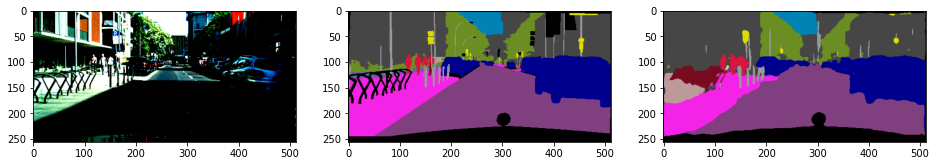

In [46]:
sample = 5
outputx= output.detach().cpu()[sample]
encoded_mask = encode_segmap(seg[sample].clone())
decoded_mask = decode_segmap(encoded_mask.clone())
decoded_output = decode_segmap(torch.argmax(outputx,0))
fig,ax = plt.subplots(ncols=3,figsize=(16,12))
ax[0].imshow(np.moveaxis(img[sample].numpy(),0,2))
ax[1].imshow(decoded_mask)
ax[2].imshow(decoded_output)

In [42]:
import shutil

shutil.move("/content/lightning_logs","/content/drive/MyDrive/Dissertation_project/pytorch_model_logs/Lightning_logs_midterm")

'/content/drive/MyDrive/Dissertation_project/pytorch_model_logs/Lightning_logs_midterm/lightning_logs'